# Vaximap dataset analysis: time saving estimates 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from pyproj import Transformer
import matplotlib.pyplot as plt
from scipy import spatial, optimize
from matplotlib.cm import get_cmap
import matplotlib.dates as mdates
from collections import Counter
import sys
sys.path.append('..')
from load_dataset import dataset as raw_dataset
import seaborn as sns 

Loading database /Users/thomaskirk/Code/vaximap_paper/analysis/../load_dataset/oct_2022.h5


`UK_CENTER` is used to shift all relative latlong coords onto the approximate center of the UK. `DETOUR_INDEX` is selected from the literature as the midpoint of the quoted range of 1.2 to 1.6. `REPEAT_THRESHOLD` is set at 21 days, the minimum permissible time between identical requests. `MAX_PAIR_DIST` is set to 64 km, the maximum allowed distance between individual patients. Distances greater than this are assumed to be due to geocoding errors and will be zeroed. 

In [2]:
CMAP = np.array(get_cmap('tab10').colors)
UK_CENTER = (53, -1.2)
DETOUR_INDEX = 1.4
REPEAT_THRESHOLD = 21 # days 
MEAN_SPEED = 50 # kmh 
MAX_PAIR_DIST = 64e3 # m 

These values are taken from the linear regressions performed in the `survey/survey_analysis` notebook; both are in minutes per patient location

In [3]:
LOOKUP_COEFFICIENT = 36.4/60
ROUTING_COEFFICIENT = 4.8/60

This is what a single row of the raw dataset (including repeats) looks like 

In [4]:
print("Length of raw dataset = {:,}".format(len(raw_dataset)))
print("Number of patients in raw dataset = {:,}".format(raw_dataset.n_patients.sum()))
raw_dataset.tail(1)

Length of raw dataset = 14,495
Number of patients in raw dataset = 436,129


,n_patients,n_clusters,latlong,clusters,region,postcodes,created,mode
14494,180,9,"[[-0.09318896016667111, -0.14464477533333397],...","[[55, 56, 53, 54, 51, 49, 50, 47, 69, 68, 70, ...",UK,"{'BA15': 1, 'SN14': 26, 'SN11': 43, 'SN12': 2,...",2022-10-05,driving


## Remove the test datasets

We need to remove the development / debug / test requests from the dataset. We do this by looking for unique sets of patient latlong coordinates, which are assigned a unique ID. Each request can then be assigned the unique ID of its latlong coordinates. The development datasets can be identified by looking for unique IDs that were uploaded a large number of times, often in quick succession, and over a long period of time. 

In [5]:
# Test to identify duplicates: need to convert latlong numpy to string beforehand to be able to drop
# We also perform a basic sort of latlong coords (on the x-dimension) to guard against cases where the 
# same set of addresses was uploaded in a new order 
def sort_latlong(arr): 
    inds = np.argsort(arr[:,0])
    return arr[inds,:]

raw_dataset["latlong_str"] = raw_dataset.latlong.apply(sort_latlong)
raw_dataset["latlong_str"] = raw_dataset.latlong.astype("str")
raw_dataset = raw_dataset.sort_values("latlong_str")

# extract number of duplicates from pandas duplicated inbuilt function
raw_dataset["is_duplicate"] = raw_dataset.duplicated(subset="latlong_str", keep="last")
print(f"Number of duplicates = {raw_dataset.is_duplicate.sum()} rows")
print(f"Number of distinct sets in dataset = {(~raw_dataset.is_duplicate).sum()} rows")

# assign unique ID to each latlong str array 
uniques = raw_dataset[~raw_dataset.latlong_str.duplicated(keep='last')][["latlong_str"]]
uid = uniques.reset_index().index
uniques["unique_id"] = uid 

Number of duplicates = 4136 rows
Number of distinct sets in dataset = 10359 rows


The vast number of duplicates in the dataset appear less than 5 times. By contrast, the development datasets are the opposite tail of this distribution, appearing many times over. 

<AxesSubplot:title={'center':'Frequency of duplicated set of lat/lons'}, xlabel='Number of duplications', ylabel='Count'>

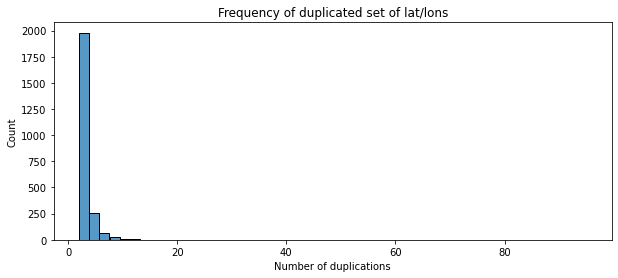

In [6]:
# plot histogram of frequency of duplicate set occurring (not showing cases without duplicates)
x = raw_dataset.groupby("latlong_str").count().sort_values("is_duplicate", ascending=False)
x = x.loc[x.is_duplicate > 1]

fig, ax = plt.subplots(figsize=(10,4))
ax.set_title("Frequency of duplicated set of lat/lons")
ax.set_xlabel("Number of duplications")
sns.histplot(x.is_duplicate, bins=50)

List the complete dataset, where each unique latlong array has been assigned a unique ID and requests are ordered by this ID. Eg 0,0,0,1,1,2,2,2,3,3 etc. 

In [7]:
dataset_repeat = pd.merge(raw_dataset, uniques[["latlong_str","unique_id"]], 
        on="latlong_str", validate="m:1")
dataset_repeat = dataset_repeat.drop(['latlong_str', 'is_duplicate'], axis=1)
dataset_repeat["created"] = pd.to_datetime(dataset_repeat["created"])

# Sanity check - assert all latlongs equal for each uid
for ui in np.unique(dataset_repeat.unique_id): 
    subset = dataset_repeat[dataset_repeat.unique_id == ui].latlong.values 
    assert all([ (subset[0] == s).all() for s in subset ])
    
dataset_repeat.head(10)

,n_patients,n_clusters,latlong,clusters,region,postcodes,created,mode,unique_id
0,24,2,"[[0.5240529250000066, 3.921018975], [0.5587271...","[[8, 1, 2, 3, 7, 5, 4, 6, 9, 18, 13, 12, 11, 1...",UK,{},2021-02-01,driving,0
1,24,2,"[[0.5240529250000066, 3.921018975], [0.5587271...","[[18, 6, 7, 5, 4, 9, 1, 8, 3, 2, 13, 12, 11, 1...",UK,{},2021-02-01,driving,0
2,24,2,"[[0.5240529250000066, 3.921018975], [0.5587271...","[[18, 6, 7, 5, 4, 9, 1, 8, 3, 2, 13, 12, 11, 1...",UK,{},2021-02-01,driving,0
3,24,2,"[[1.5274333159128801, -2.1438791751861572], [1...","[[7, 8, 22, 1, 6, 14, 0, 3, 11, 13, 17, 4, 10,...",UK,{},2021-02-12,driving,1
4,24,2,"[[1.5274333159128801, -2.1438791751861572], [1...","[[7, 8, 22, 1, 6, 14, 0, 3, 11, 13, 17, 4, 10,...",UK,{},2021-02-12,driving,1
5,24,2,"[[1.5274333159128801, -2.1438791751861572], [1...","[[7, 8, 22, 1, 6, 14, 0, 3, 11, 13, 17, 4, 10,...",UK,{},2021-02-12,driving,1
6,24,2,"[[1.5274333159128801, -2.1438791751861572], [1...","[[7, 8, 22, 1, 6, 14, 0, 3, 11, 13, 17, 4, 10,...",UK,{},2021-02-12,driving,1
7,10,1,"[[2.08087414887207, -3.1204763505982402], [2.0...","[[5, 3, 7, 0, 1, 9, 2, 6, 8, 4]]",UK,{},2021-02-12,driving,2
8,10,1,"[[2.08087414887207, -3.1204763505982402], [2.0...","[[5, 3, 7, 0, 1, 9, 2, 6, 8, 4]]",UK,{},2021-02-12,driving,2
9,172,15,"[[0.0001002688740570079, -0.00950693391090196]...","[[6, 18, 105, 34, 93, 35, 29, 7, 120, 121, 44,...",UK,"{'WN5': 134, 'WN3': 14, 'WN1': 17, 'WN2': 1, '...",2021-12-09,driving,3


Calculate the time in between repeated requests. `Days to last` is the days since that unique ID first appears in the dataset, and `days to next` is the days until it next appears. 

In [8]:
time_final = np.zeros(dataset_repeat.shape[0], int)
dataset_repeat = dataset_repeat.sort_values(['unique_id', 'created'])

for uid in range(dataset_repeat.unique_id.max()+1): 
    fltr = np.flatnonzero(dataset_repeat.unique_id == uid)
    if fltr.size < 2: 
        continue
    end = dataset_repeat.iloc[fltr[-1]].created
    for row in fltr[:-1]: 
        start = dataset_repeat.iloc[row].created
        t = (end - start).days 
        time_final[row] = t 

dataset_repeat["days_to_last"] = time_final
dataset_repeat["days_to_next"] = (dataset_repeat.days_to_last - dataset_repeat.days_to_last.shift(-1)).fillna(0).astype(int)
dataset_repeat["days_to_next"] = dataset_repeat["days_to_next"].clip(lower=0)
dataset_repeat.head(10)

,n_patients,n_clusters,latlong,clusters,region,postcodes,created,mode,unique_id,days_to_last,days_to_next
0,24,2,"[[0.5240529250000066, 3.921018975], [0.5587271...","[[8, 1, 2, 3, 7, 5, 4, 6, 9, 18, 13, 12, 11, 1...",UK,{},2021-02-01,driving,0,0,0
1,24,2,"[[0.5240529250000066, 3.921018975], [0.5587271...","[[18, 6, 7, 5, 4, 9, 1, 8, 3, 2, 13, 12, 11, 1...",UK,{},2021-02-01,driving,0,0,0
2,24,2,"[[0.5240529250000066, 3.921018975], [0.5587271...","[[18, 6, 7, 5, 4, 9, 1, 8, 3, 2, 13, 12, 11, 1...",UK,{},2021-02-01,driving,0,0,0
3,24,2,"[[1.5274333159128801, -2.1438791751861572], [1...","[[7, 8, 22, 1, 6, 14, 0, 3, 11, 13, 17, 4, 10,...",UK,{},2021-02-12,driving,1,0,0
4,24,2,"[[1.5274333159128801, -2.1438791751861572], [1...","[[7, 8, 22, 1, 6, 14, 0, 3, 11, 13, 17, 4, 10,...",UK,{},2021-02-12,driving,1,0,0
5,24,2,"[[1.5274333159128801, -2.1438791751861572], [1...","[[7, 8, 22, 1, 6, 14, 0, 3, 11, 13, 17, 4, 10,...",UK,{},2021-02-12,driving,1,0,0
6,24,2,"[[1.5274333159128801, -2.1438791751861572], [1...","[[7, 8, 22, 1, 6, 14, 0, 3, 11, 13, 17, 4, 10,...",UK,{},2021-02-12,driving,1,0,0
7,10,1,"[[2.08087414887207, -3.1204763505982402], [2.0...","[[5, 3, 7, 0, 1, 9, 2, 6, 8, 4]]",UK,{},2021-02-12,driving,2,0,0
8,10,1,"[[2.08087414887207, -3.1204763505982402], [2.0...","[[5, 3, 7, 0, 1, 9, 2, 6, 8, 4]]",UK,{},2021-02-12,driving,2,0,0
9,172,15,"[[0.0001002688740570079, -0.00950693391090196]...","[[6, 18, 105, 34, 93, 35, 29, 7, 120, 121, 44,...",UK,"{'WN5': 134, 'WN3': 14, 'WN1': 17, 'WN2': 1, '...",2021-12-09,driving,3,0,0


For the unique IDs that appear most often (ie, most repeated), print the duration in days from the first appearance until the last. This tells us which datasets were uploaded repeatedly in quick succession, and over a long period of time, which are the test datasets. 

In [9]:
for uid in range(dataset_repeat.unique_id.max()+1): 
    fltr = np.flatnonzero(dataset_repeat.unique_id == uid)
    dates = sorted(dataset_repeat.iloc[fltr].created)

    if len(dates) > 15: 
        print(uid, [ (dates[-1] - d).days for d in dates[:-1] ])

147 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3341 [379, 378, 353, 266, 247, 222, 219, 177, 177, 177, 169, 169, 169, 162, 162, 149, 111, 49]
3342 [105, 105, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 100, 100, 100, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 95, 95, 95, 95, 94, 35, 9]
3343 [68, 68, 66, 66, 66, 65, 65, 65, 65, 65, 63, 63, 63, 55, 30, 22, 22, 22, 22, 14, 14]
3449 [13, 13, 13, 13, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 6, 6, 5, 5, 5]
5594 [17, 17, 17, 17, 17, 17, 13, 13, 13, 13, 13, 13, 12, 12, 12]
9550 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


3341, 3342, 3343 are the test sets used during development (24 patients, driving, OX postcodes), so drop them from further analysis

In [10]:
for idx in [3341, 3342, 3343]: 
    dataset_repeat = dataset_repeat[dataset_repeat.unique_id != idx]
    

## Repeat analysis 
The irrelevant repeats have been removed; what can we say about the ones that remain?

First we drop repeats that occurred within `REPEAT_THRESHOLD` days of each other as these are trivial. 

In [11]:
valid_repeats = dataset_repeat[dataset_repeat.days_to_next >= REPEAT_THRESHOLD]
last_repeats = dataset_repeat[~dataset_repeat.unique_id.duplicated(keep='last')]
last_repeats = last_repeats[last_repeats.unique_id.isin(valid_repeats.unique_id)]
valid_repeats = pd.concat([valid_repeats, last_repeats])
valid_repeats = valid_repeats.sort_values('unique_id')
counts = valid_repeats.unique_id.value_counts().to_frame().rename({'unique_id': "rpt_count"}, axis=1)
valid_repeats = pd.merge(valid_repeats, counts, left_on='unique_id', right_index=True)
valid_repeats = valid_repeats.sort_values('rpt_count')
valid_repeats.head(10)

,n_patients,n_clusters,latlong,clusters,region,postcodes,created,mode,unique_id,days_to_last,days_to_next,rpt_count
4123,8,1,"[[0.014923572540283203, -0.09073472023010254],...","[[6, 3, 4, 0, 5, 2, 1, 7]]",UK,{},2021-03-25,driving,3037,25,25,2
11700,18,1,"[[-0.019414054022895755, 0.0018396493461396712...","[[10, 14, 11, 15, 16, 17, 13, 6, 12, 8, 9, 4, ...",UK,"{'BN12': 4, 'BN13': 14}",2021-07-15,driving,8447,96,96,2
11701,18,2,"[[-0.019414054022895755, 0.0018396493461396712...","[[10, 14, 11, 15, 16, 17, 12, 8, 9, 4, 5, 7], ...",UK,"{'BN12': 4, 'BN13': 14}",2021-10-19,driving,8447,0,0,2
11682,7,1,"[[-0.019066401890349027, 0.000491133757999973]...","[[2, 3, 0, 5, 6, 1, 4]]",UK,{},2021-03-02,driving,8433,182,182,2
11681,7,1,"[[-0.019066401890349027, 0.000491133757999973]...","[[2, 3, 0, 5, 6, 1, 4]]",UK,"{'SG17': 3, 'SG16': 2, 'MK45': 2}",2021-08-31,driving,8433,0,0,2
11396,18,2,"[[-0.014597998725044192, -0.005178776052263023...","[[6, 7, 8, 9, 14, 12, 13, 1, 0, 4, 5], [3, 2, ...",UK,"{'PO1': 7, 'PO2': 5, 'PO3': 3, 'PO6': 3}",2021-12-16,driving,8215,28,28,2
11395,18,2,"[[-0.014597998725044192, -0.005178776052263023...","[[6, 7, 8, 9, 14, 12, 13, 1, 4, 0, 3, 5], [2, ...",UK,"{'PO1': 7, 'PO2': 5, 'PO3': 3, 'PO6': 3}",2022-01-13,driving,8215,0,0,2
9898,6,1,"[[-0.006197611490883048, -0.012261168410380677...","[[2, 4, 1, 3, 0, 5]]",UK,"{'CR0': 2, 'SE25': 2, 'CR7': 2}",2021-06-09,driving,7096,134,134,2
9894,6,1,"[[-0.006197611490883048, -0.012261168410380677...","[[2, 4, 1, 3, 0, 5]]",UK,"{'CR0': 2, 'SE25': 2, 'CR7': 2}",2021-10-21,driving,7096,0,0,2
8943,6,1,"[[-0.0036245981852189857, -0.00343434015909815...","[[2, 3, 0, 1, 4, 5]]",UK,{'HR2': 6},2022-03-14,driving,6410,0,0,2


Compare the datasets with and without repeats.

In [12]:
repeated = dataset_repeat.unique_id.duplicated(keep='last')
dataset_nonrepeat = dataset_repeat[~repeated]
print("Length of dataset with repeats = {:,}".format(len(dataset_repeat)))
print("Number of repeats found = {:,}".format(len(repeated) - len(dataset_nonrepeat)))
print("Length of dataset without repeats = {:,}".format(len(dataset_nonrepeat)))
print("Number of patients in dataset with repeats = {:,}".format(dataset_repeat.n_patients.sum()))
print("Number of patients in dataset without repeats = {:,}".format(dataset_nonrepeat.n_patients.sum()))

Length of dataset with repeats = 14,359
Number of repeats found = 4,003
Length of dataset without repeats = 10,356
Number of patients in dataset with repeats = 432,865
Number of patients in dataset without repeats = 285,453


## Time savings in planning 

These are calculated simply by using the survey derived coefficients and multiplying by the number of patients in each request. A 30 second penalty is applied for the time to run vaximap. 

In [13]:
lookup_time = dataset_repeat.n_patients.sum() * LOOKUP_COEFFICIENT
routing_time = dataset_repeat.n_patients.sum() * ROUTING_COEFFICIENT 
planning_penalty = dataset_repeat.shape[0] * 0.5 # this is a 30 sec penalty per request; the time taken to setup and run vaximap 
planning_time_hrs = (lookup_time + routing_time - planning_penalty) / 60
print('Time saved in planning %d hours' % planning_time_hrs)
print('Time saved in planning %d weeks (40hr week)' % (planning_time_hrs / 40))

Time saved in planning 4834 hours
Time saved in planning 120 weeks (40hr week)


## Time savings in travelling 
We are lifting the optimisation penalty function for human performance reported in figure 2b of Dry, Matthew; Lee, Michael D; Vickers, Douglas; Hughes, Peter; Human Performance on Visually Presented Traveling Salesperson Problems with Varying Numbers of Nodes, The Journal of Problem Solving, 2006

In [14]:
# optimisation penalty 
n = np.array([0, 10, 20, 30, 40, 50, 70, 90, 120])
p = np.array([0, 0.02, 0.025, 0.06, 0.075, 0.095, 0.105, 0.11, 0.12])

# Assume a relation of the form y = A(1 - e(-n/B))
def curve(x, A, B):
    return A * (1 - np.exp(-x / B))

params = optimize.curve_fit(curve, n.flatten(), p.flatten())[0]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


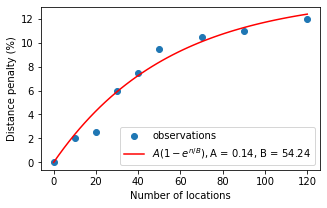

In [15]:
plt.figure(figsize=(5,3))
plt.scatter(n.flat, 100 * p.flatten(), label='observations')
n_fit = np.linspace(0,120)
p_fit = curve(n_fit, *params)
plt.plot(n_fit, 100 * p_fit, 'r-', label=r'$A(1 - e^{n/B}), $' + f'A = {params[0]:.2f}, B = {params[1]:.2f}' )

plt.xlabel('Number of locations')
plt.ylabel('Distance penalty (%)')
# plt.title('Dry\'s empirical model of human solution quality')
plt.legend(loc='lower right')
plt.savefig('../paper/figs/dry_model.eps', dpi=250, bbox_inches='tight')

In [16]:
# Calculating the distance implied by all Vaximap routes. 
# The coordinates are stored in the dataset as latitude and longitude, so we need to convert into a metric 
# coordinate system (EPSG3857) and then can use distance matrices to work out the length of each closed route 
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

def get_vaximap_route_length(latlong, routes):
    lat, lng = (latlong + UK_CENTER).T
    ll_m = transformer.transform(lng, lat)
    ll_m = np.vstack(ll_m).T
    dm = spatial.distance_matrix(ll_m, ll_m)
    dm[dm > MAX_PAIR_DIST] = 0 
    total = 0 
    for route in routes: 
        rt_length = sum([ dm[route[x], route[x+1]] for x in range(len(route) - 1) ])
        rt_length += dm[route[-1], route[0]]
        total += rt_length
    return total

# Calculate total length of routes for each request (ie, row of dataset). Then, we can apply the manual distance
# penalty which is a function of the total number of patients in the request 
dataset_nonrepeat = dataset_nonrepeat.assign(vaximap_distance=[ 
                        get_vaximap_route_length(row.latlong, row.clusters) 
                        for row in dataset_nonrepeat.loc[:,['latlong', 'clusters']].itertuples() ])
dataset_nonrepeat =  dataset_nonrepeat.assign(manual_distance= 
                        (dataset_nonrepeat['vaximap_distance'] 
                         * (1 + params[0] * (1 - np.exp(-dataset_nonrepeat['n_patients'] / params[1])))))

In [17]:
# Route lengths are in meters. Apply the detour index, convert into km, and apply average speed to convert into time 
dist_saving = DETOUR_INDEX * (dataset_nonrepeat['manual_distance'] - dataset_nonrepeat['vaximap_distance']).sum() / 1000
dist_saving_hrs = dist_saving / 50
print('travel savings %d km' % dist_saving)
print('travel savings %d hours' % dist_saving_hrs)
print('travel savings %d weeks (40hr week)' % (dist_saving_hrs / 40))
total_savings_hrs = dist_saving_hrs + planning_time_hrs
print('total savings %d hours' % total_savings_hrs)
print('total savings %d weeks (40hr week)' % (total_savings_hrs / 40))

travel savings 44209 km
travel savings 884 hours
travel savings 22 weeks (40hr week)
total savings 5718 hours
total savings 142 weeks (40hr week)


## Cost savings

In [18]:
# Convert into cost savings 
pm_salary = 38e3 # practice manager
cn_salary = 32e3 # community nurse 
total_cost_savings = (pm_salary * planning_time_hrs / (40 * 48)) + (cn_salary * dist_saving_hrs / (40 * 48))
print('Total cost savings (GBP)', total_cost_savings)

Total cost savings (GBP) 110414.11728082248


## Summary plots 
A variety of plots showing high level summaries of dataset 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


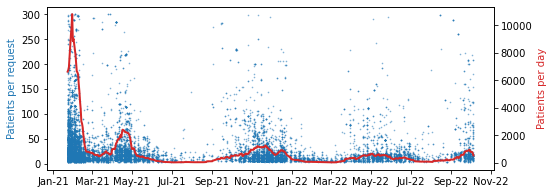

In [19]:
# sort the dataframe by date created
dataset_repeat['created'] = pd.to_datetime(dataset_repeat.created)
dataset_repeat = dataset_repeat.sort_values(by='created')

# define average patients per cluster
dataset_repeat['patients_per_cluster'] = (dataset_repeat['n_patients']/dataset_repeat['n_clusters'])

# get the raw data
y = dataset_repeat.n_patients
x = dataset_repeat.created

# bin the data by date
binned = dataset_repeat['n_patients'].groupby(dataset_repeat['created']).sum()
x_binned = binned.index
y_binned = binned.values

def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

def add_titlebox(ax, text):
    ax.text(.67, .8, text,
        horizontalalignment='center',
         transform=ax.transAxes,
         bbox=dict(facecolor='white', alpha=0.2),
         fontsize=12.5)
    return ax

fig, ax1 = plt.subplots(1,1, figsize=(8, 3))
ax11= ax1.twinx()

# Headline figure
# fig.suptitle('Patients per request (LHS) and per day (RHS)',
#               fontsize=14)
sctr = ax1.scatter(x, y, color='tab:blue', alpha=0.5, s=0.4)
y_av = movingaverage(y_binned, 14)
ax11.plot(x_binned, y_av, "tab:red", linewidth=2)
ax1.set_yscale('linear')
ax1.set_ylabel('Patients per request', color='tab:blue')
#ax1.text(0.8, 0.8, r'A', fontsize=15,transform=ax.transAxes)
ax11.set_ylabel('Patients per day', color='tab:red')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
plt.savefig('../paper/figs/timeseries.eps', dpi=250, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


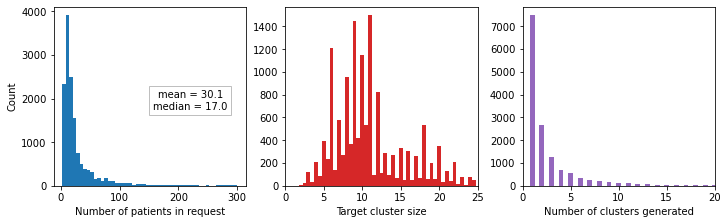

In [20]:
# Patients per route
fig, axes = plt.subplots(1, 3, figsize=(10, 3), constrained_layout=True)

ax1 = axes[0]
ax1.hist(dataset_repeat.n_patients, bins=50)
ax1.set_xlabel('Number of patients in request')
ax1.set_ylabel('Count')
# ax1.set_title('Patients per request')
ax1.text(220, 1750, f'mean = {dataset_repeat.n_patients.mean():.1f}\n'
                    +f'median = {dataset_repeat.n_patients.median():.1f}',
        horizontalalignment='center',
        bbox=dict(facecolor='white', alpha=0.25))

ax2 = axes[1]
binwidth=0.5
ax2.hist(dataset_repeat.patients_per_cluster, bins=np.arange(min(dataset_repeat.patients_per_cluster), 
                                                      max(dataset_repeat.patients_per_cluster) + binwidth, binwidth),
         color='tab:red', align='left')
ax2.axis(xmin=0,xmax=25)
# ax2.set_title('Cluster size for request')
ax2.set_xlabel('Target cluster size')

# Clusters per route
ax3 = axes[2]
binwidth=0.5
ax3.hist(dataset_repeat.n_clusters, bins=np.arange(min(dataset_repeat.n_clusters), 
                                            max(dataset_repeat.n_clusters) + binwidth, binwidth),
                                            align='left', color='tab:purple')
ax3.axis(xmin=0,xmax=13.5)
# ax3.set_title('Clusters per request')
ax3.set_xlabel('Number of clusters generated')
ax3.set_xlim(0,20)

plt.savefig('../paper/figs/hists.eps', dpi=250, bbox_inches='tight')

## Geographic analysis
Extract postcodes to CSV (to be plotted via another program not available here)

In [21]:
has_pc = [ bool(pc) for pc in dataset_repeat.postcodes ]
print(f'{len(has_pc)} rows, {sum(has_pc)} have postcodes')

14359 rows, 7977 have postcodes


In [22]:
pc_counts = Counter() 
[ pc_counts.update(pc) for pc in dataset_repeat.postcodes.tolist() ] 

df = pd.DataFrame(data={"postcodes" : pc_counts.keys(), "num" : pc_counts.values()})
df1 = df.groupby("postcodes").sum()
df1["name"] = df1.index.str[:2]
df1.to_csv("../paper/figs/postcodes.csv", header=True)